In [83]:
import pandas as pd 
import numpy as np
from time import strftime
from scipy.stats import zscore
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import IPython.display as ipd
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA
from scipy.spatial import distance
from collections import Counter
from imblearn.over_sampling import SMOTE
from prettytable import PrettyTable

import warnings
warnings.filterwarnings('ignore')

## OBSERVING THE DATASET

Every record of the dataset is composed of 10 column labels. We use the first column to retrieve the associated audio file. The concatenation of the columns "action" and "object" represents the labels we want to classify linked to the record. 

In order to create a more accurate model, our choice is to drop the records where the "self-reported fluency level" is "intermediate" or "basic" since they represent less than 0.7% of the whole dataset and are not present in the evaluation set. 

In [3]:
df1 = pd.read_csv("dsl_data/development.csv")
print(f"Starting shape of the dataset: {df1.shape}")
df1.drop(df1.loc[(df1['Self-reported fluency level ']=="intermediate" )|(df1['Self-reported fluency level ']=="basic")].index, inplace=True)

df1 = df1.reset_index(drop=True)
df = pd.DataFrame(df1)
df_eval = pd.read_csv("dsl_data/evaluation.csv")

#TRAINING SET AND TEST SET
print(f"Reworked dataset shape: {df.shape}\nEvaluation set shape: {df_eval.shape}")



Starting shape of the dataset: (9854, 10)
Reworked dataset shape: (9790, 10)
Evaluation set shape: (1455, 8)


## PREPROCESSING

The preprocessing part is the most crucial one. In this case we are working with audio files, so it can be useful to study the type of data in both time and frequency domains, in order to analyze it through different perspectives.

Taking into account that the goal of the model has to be the identification of voice commands, our strategy is to describe every audio file in terms of MFCCs (Mel-Frequency Cepstral Coefficients). The MFCCs are largely used in speech recognition and is it know to perform best as features to feed a machine learning algorithm. 

Below we find some of the functions we use to preprocess and analyze the data

In [4]:
#AUDIO ADJUST: split the signal and remove insignificant parts

def audio_adjust(y, sr, top_db):
    segments = librosa.effects.split(y=y, top_db=top_db)
    min_length = sr * 0.16  # 0.2 seconds
    segments = [ [start,end] for start, end in segments if ((end-start)> min_length)]
    y_new = [y[start:end] for start, end in segments]
    if len(y_new) == 0:
        #print("problem")
        return np.array([-1])
    return np.concatenate([x.ravel() for x in y_new])

In [5]:
"""
Time series preprocessing function
    1. Trimming of the audio to remove silence parts at the beggining and at the end
    2. Apply the adjustment function to remove irrelevant parts in the audio
    3. Apply preemphasis so we amplify the voices and reduce some noise
    4. Apply a mean subtraction of 80% to remove some noise so we do not remove possibile significant values
    5. Apply a zscore normalization: z = (x - mean)/std so we have a signal with normalized amplitude
"""
def time_signal_preprocess(y,sr, gender):
    y_new,_ = librosa.effects.trim(y=y, top_db=35)
    y_new   = audio_adjust(y_new,sr, 25)
    if len(y_new)==1: 
        return y_new

    y_new   = librosa.effects.preemphasis(y=y_new, coef=0.97)
    if gender=='male':
        y_new = librosa.effects.pitch_shift(y=y_new, sr=sr, n_steps=2)
    
    return np.array(y_new)

In [6]:
"""
Mel-Frequency cepstral coefficients preprocessing function
    1. Converting time-series to MFCC
    2. CMS (Cepstral Mean Subtraction) normalization
    3. Zscore normalization
"""
def mfcc_signal_preprocess(y,sr):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc = mfcc - mfcc_mean[:,np.newaxis]
    mfcc = zscore(mfcc)                              #single sample normalization
    return mfcc

In [7]:
#NORMALIZE: z-normalization

def normalize(mfcc):
    mean = mfcc.mean()
    std = mfcc.std()
    mfcc = (mfcc-mean)/std
    return mfcc

In [8]:
#COMPUTEMFCC: application of the function "mfcc_signal_preprocess" for every sample

def computeMFCC(samples, sr):
    mfccs = list();
    for s in samples:
        mfcc = mfcc_signal_preprocess(s,sr)
        mfcc = mfcc.reshape(mfcc.shape[0]*mfcc.shape[1])
        mfccs.append(mfcc)
    return np.array(mfccs)

In [9]:
#LOAD_DATA: a function that retrieves the audio files and transform them into time series. There are two possible mode:

#DEV MODE: checking if the file audio is not too long or too short (in this case is intended as outlier). This mode stores 
#the audios as time series, the durations of the audios and the label associated to them. The durations have been used to stretch
#the audios, so that all of them have the same length

#EVAL MODE: transforming the audio file in the evaluation set in time series


duration_threshold_low = 4608     #minimum number of samples accepted
duration_threshold_high = 56000   #maximum number of samples accepted

def load_data(df, mode, dur):
    
    durations    = list()
    time_samples = list()
    labels       = list()
    
    for index, entry in df.iterrows():
        path = entry['path']
        ytmp, sr = librosa.load(path, sr = None)
        ytmp = time_signal_preprocess(ytmp, sr, entry['gender'])

        duration = len(ytmp)
        if mode == 'dev':
            if  ytmp[0] == -1 or duration < duration_threshold_low or duration > duration_threshold_high : 
                print(f"Deleted outlier: {index} with duration: {round(duration/sr,3)}sec")
                #df.drop(df.loc[(df['Id']==index)].index, inplace=True)
                #df = df.reset_index(drop=True)
                continue 
            
            label = entry['action']+entry['object']
            labels.append(label)
            
        ytmp = librosa.effects.time_stretch(y=ytmp, rate=duration/dur)
        ytmp   = zscore(ytmp)
        
        time_samples.append(ytmp)
        durations.append(duration/sr)
 
    if mode == 'dev':
        return np.array(time_samples), np.array(durations), np.array(labels)
    
    if mode == 'eval':
        return np.array(time_samples),np.array(durations)

In [10]:
#PREPARE DATA: applying PCA, principal component analysis, to the features extracted exploiting MFCCs, 
#both in development and evaluation set. 

#Due to the fact that we have to work with a lot of features, it is necessary to apply the PCA, in order to reduce them 
#and obtain advantages in terms of time and space.

#here the z-normalization is applied before and after the PCA, so that we could work with an homogeneous collection of data.


def prepare_data(mfcc, eval_mfcc, ncomp):
    mfcc = normalize(mfcc)                   #whole sample dataset normalization
    eval_mfcc = normalize(eval_mfcc)
    pca = PCA(n_components=ncomp)
    pca.fit(mfcc)
    mfcc = pca.transform(mfcc)
    
    eval_mfcc = pca. transform(eval_mfcc)
    mfcc = normalize(mfcc)
    eval_mfcc = normalize(eval_mfcc)
    return mfcc, eval_mfcc

### *EXAMPLE*

Here is an example that shows all the steps we do on every audio file.

In time domain:
- PREEMPHASIS
- TRIMMING
- AUDIO ADJUSTING
- TIME STRETCHING

In frequency domain:

- MFCC CONVERSION
- CEPSTRAL MEAN SUBTRACTION is a technique used to remove the first-order dependencies of the cepstral coefficients (MFCCs) on the global power of the speech signal.
- Z-NORMALIZATION (CMVN)


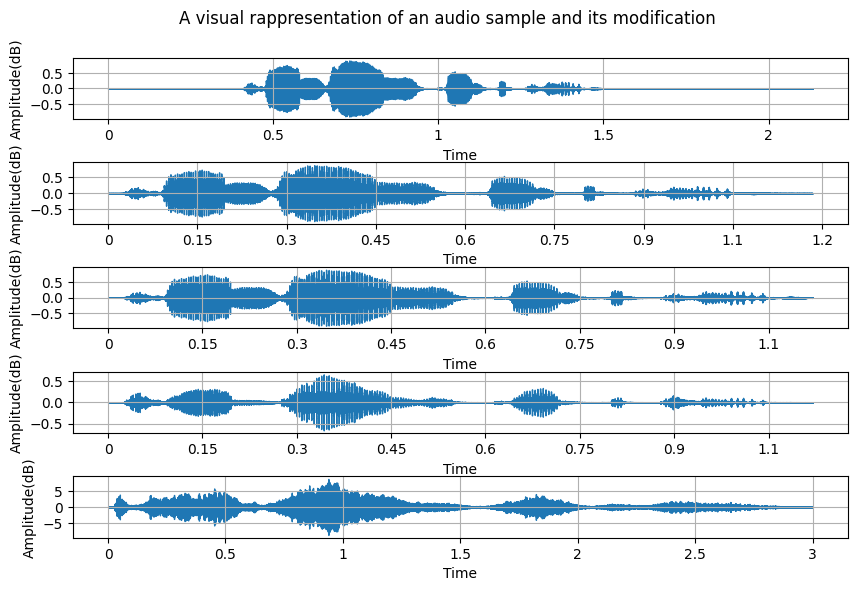

In [11]:
y_ex = [0]*5
y_ex[0],sr = librosa.load(df['path'][9000], sr = None)

y_ex[1],_ = librosa.effects.trim(y=y_ex[0], top_db=35)
y_ex[2]   = audio_adjust(y_ex[1],sr, 25)
y_ex[3]   = librosa.effects.preemphasis(y=y_ex[2], coef=0.97)
y_ex[4]   = zscore(librosa.effects.time_stretch(y=y_ex[3], rate=len(y_ex[3])/48000))
ipd.display(ipd.Audio(y_ex[0], rate=sr))

fig, ax = plt.subplots(5, figsize=(10,6))

fig.subplots_adjust(hspace=0.7, top=0.9, bottom=0.1)
fig.suptitle('A visual rappresentation of an audio sample and its modification')

for i in range(5):
    ax[i].set(xlabel='Time(sec)', ylabel='Amplitude(dB)')
    ax[i].grid()
    librosa.display.waveshow(y_ex[i], sr=sr, ax=ax[i])

plt.show()
ipd.display(ipd.Audio(y_ex[3], rate=sr))

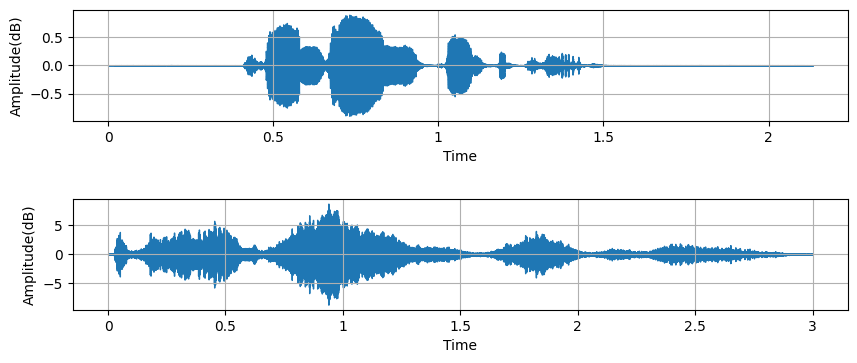

In [12]:
fig, ax = plt.subplots(2, figsize=(10,5))

fig.subplots_adjust(hspace=0.7, top=0.7, bottom=0.1)
ax[0].set(xlabel='Time(sec)', ylabel='Amplitude(dB)')
ax[0].grid()
ax[1].grid()
ax[1].set(xlabel='Time(sec)', ylabel='Amplitude(dB)')
#ax[0].set(title='Audio before time preprocessing')
#ax[1].set(title='Audio after time preprocessing')
librosa.display.waveshow(y_ex[0], sr=sr, ax=ax[0])
librosa.display.waveshow(y_ex[-1], sr=sr, ax=ax[-1])

fig.savefig('time_steps.eps', format='eps', dpi=1200, bbox_inches='tight')
plt.show()

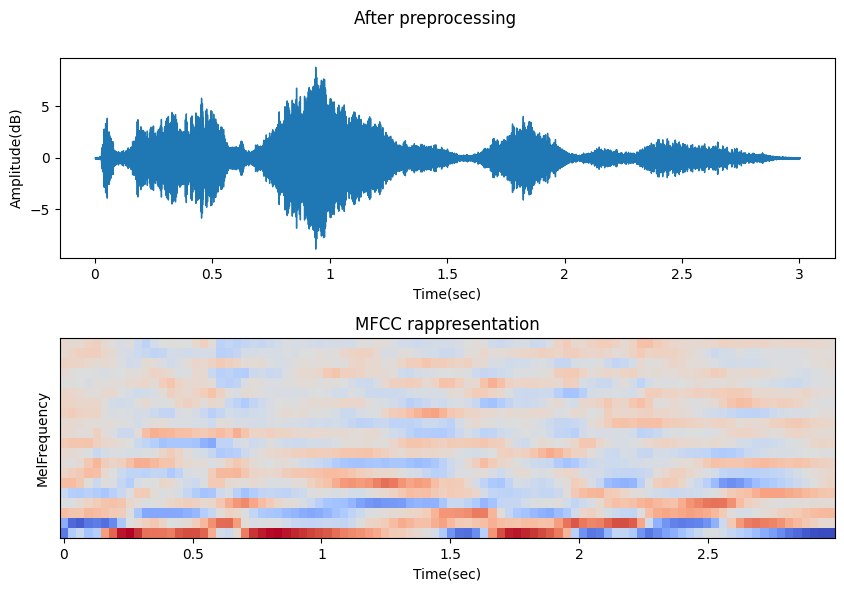

In [13]:
mfcc_ex_mod = mfcc_signal_preprocess(y_ex[-1],sr)

fig, ax = plt.subplots(2, figsize=(10,6))
fig.subplots_adjust(hspace=0.4, top=0.9, bottom=0.1)
fig.suptitle('After preprocessing')

librosa.display.waveshow(y_ex[-1], sr=sr, ax=ax[0])
ax[0].set(xlabel='Time(sec)', ylabel='Amplitude(dB)')

librosa.display.specshow(mfcc_ex_mod, sr=sr, ax=ax[1], x_axis='time')#, y_axis='linear', x_axis='time')
ax[1].set(xlabel='Time(sec)', ylabel='MelFrequency', title='MFCC rappresentation')
plt.show()


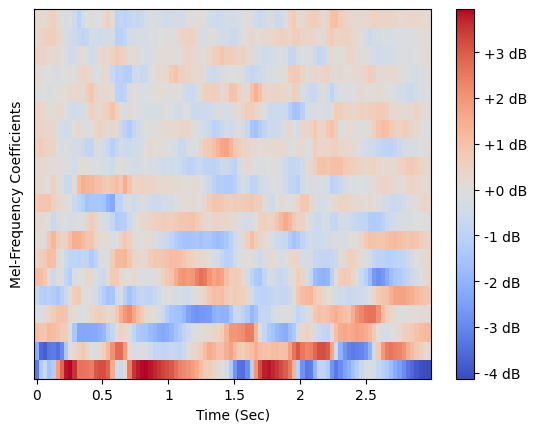

In [14]:
librosa.display.specshow(mfcc_ex_mod, sr=sr, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.xlabel("Time (Sec)")
plt.ylabel("Mel-Frequency Coefficients")
plt.savefig('mfcc.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()


After applying CMVN (zscore) it seems that we created more noise, but actually this normalization makes the audio more recognizable since we can ensure that the MFCCs are both power-normalized (CMS) and scale-normalized (CMVN).

## DATA LOADING

In [15]:
#LOADING DEVELOPMENT SET

samples, durations, labels = load_data(df, mode='dev', dur=48000)
samples.shape, labels.shape, samples.var()

Deleted outlier: 25 with duration: 3.68sec
Deleted outlier: 75 with duration: 3.648sec
Deleted outlier: 341 with duration: 2.554sec
Deleted outlier: 569 with duration: 4.96sec
Deleted outlier: 1448 with duration: 0.256sec
Deleted outlier: 1857 with duration: 0.224sec
Deleted outlier: 1966 with duration: 0.192sec
Deleted outlier: 2028 with duration: 0.224sec
Deleted outlier: 2594 with duration: 3.904sec
Deleted outlier: 3011 with duration: 2.554sec
Deleted outlier: 3023 with duration: 6.502sec
Deleted outlier: 3025 with duration: 0.186sec
Deleted outlier: 8077 with duration: 3.776sec
Deleted outlier: 8166 with duration: 3.68sec


((9776, 48000), (9776,), 0.9999962)

In [16]:
#LOADING EVALUATION SET

eval_samples, eval_durations = load_data(df_eval, mode='eval', dur=48000)
eval_samples.shape, eval_samples.var()

((1455, 48000), 0.99999976)

# DATA ANALYSIS 

Before starting with getting the samples and training the model we want to analyze the data to see if, and how many, outliers are present. We also know that some samples might have long audio, but after a preprocessing they are much shorter.

1.0766487589435325


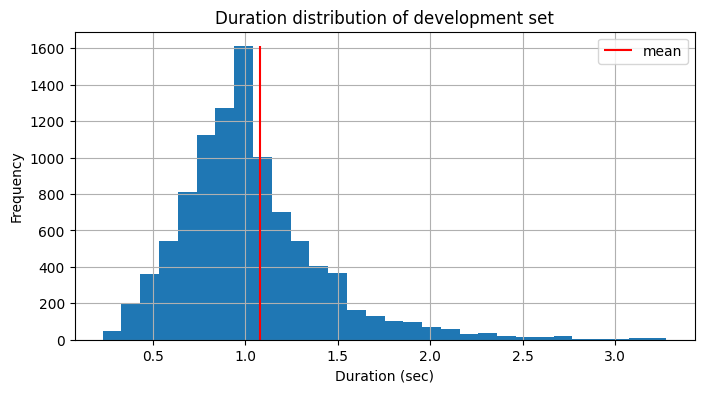

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [84]:
hist1, edges1 = np.histogram(durations, bins=30)
print(durations.mean())
# Plot the histogram as a bar chart
fig, ax = plt.subplots(1, figsize=(8,4))

ax.grid()
ax.bar(edges1[:-1], hist1, width=np.diff(edges1), align='center')
ax.set(title='Duration distribution of development set', xlabel='Duration (sec)', ylabel='Frequency')
ax.vlines(np.array(durations).mean(), ymin=0, ymax=max(hist1), colors='r', label='mean')
plt.legend()
plt.show()
fig.savefig('durations.eps', format='eps', dpi=1200, bbox_inches='tight')

The plot above shows us how the lengths of the time series are different in the development set. In order to standardize the data, we decide to apply a time stretching function, so that the series will have the same length. Since most of the audios have less than 3.0 sec we stretch all of them to 48000 samples.

1.0725388745704467


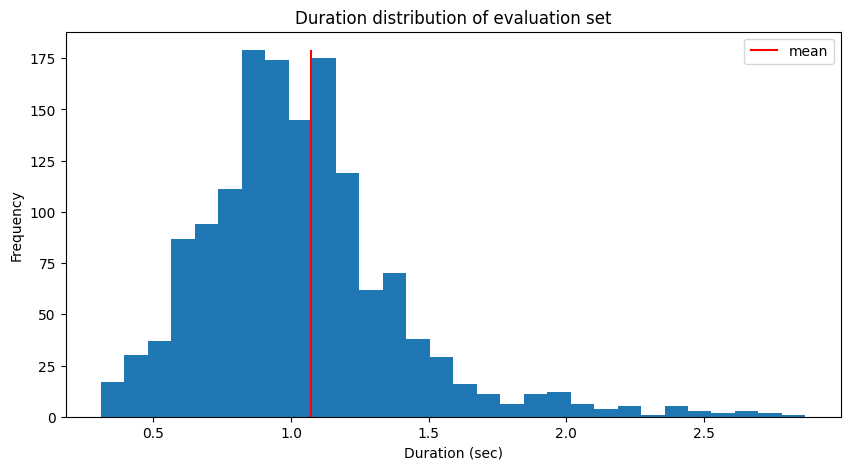

In [62]:
hist1, edges1 = np.histogram(eval_durations, bins=30)
print(eval_durations.mean())
# Plot the histogram as a bar chart
fig, ax = plt.subplots(1, figsize=(10,5))
ax.bar(edges1[:-1], hist1, width=np.diff(edges1), align='center')
ax.set(title='Duration distribution of evaluation set', xlabel='Duration (sec)', ylabel='Frequency')
ax.vlines(np.array(eval_durations).mean(), ymin=0, ymax=max(hist1), colors='r', label='mean')
plt.legend()
plt.show()
#fig.savefig('eval_durations.eps', format='eps', dpi=1200, bbox_inches='tight')

In [19]:
#TRANSFORMATION OF THE TIME SERIES (development set) IN MFCCs
#We set the duration of all samples to 3 seconds

dev_mfccs = computeMFCC(samples,sr)
dev_mfccs.shape

(9776, 1880)

In [20]:
#TRANSFORMATION OF THE TIME SERIES (evaluation set) IN MFCCs

eval_mfccs = computeMFCC(eval_samples,sr)   
eval_mfccs.shape

(1455, 1880)

In [21]:
len(dev_mfccs), len(samples), len(labels), len(eval_samples), len(eval_mfccs)

(9776, 9776, 9776, 1455, 1455)

# DATA CLEANING

Once we have all data, we can proceed to clean the outliers. First we find those that have a meaningless duration (by testing we found out that the shortest meaningful duration is 'Play' with 0.288 sec). Next we calculate, for each label, the mean by colums of each audio sample, so we have a maxlength_mean sample for each label. Then for each label we compare the corresponding mean with the audio sample and if the Manhattan distance is big we can say it's an outlier.

In [67]:
#New variables, so we don't have to do the reading&transformation again
new_labels = labels
dev_mfcc_final = dev_mfccs

In [68]:
#Creating a dataframe containing only the recordings and labels so we can group by label.
#We then calculate for each class a sample mean and use it as reference.

dataset = pd.DataFrame({'mfccs':list(dev_mfcc_final), 'labels': new_labels})
groupLabel = dataset.groupby('labels')

dataset.shape

(9776, 2)

Outliers activatemusic: 27
Outliers change languagenone: 81
Outliers deactivatelights: 4
Outliers decreaseheat: 4
Outliers decreasevolume: 40
Outliers increaseheat: 4
Outliers increasevolume: 22
Number of outliers in total: 182


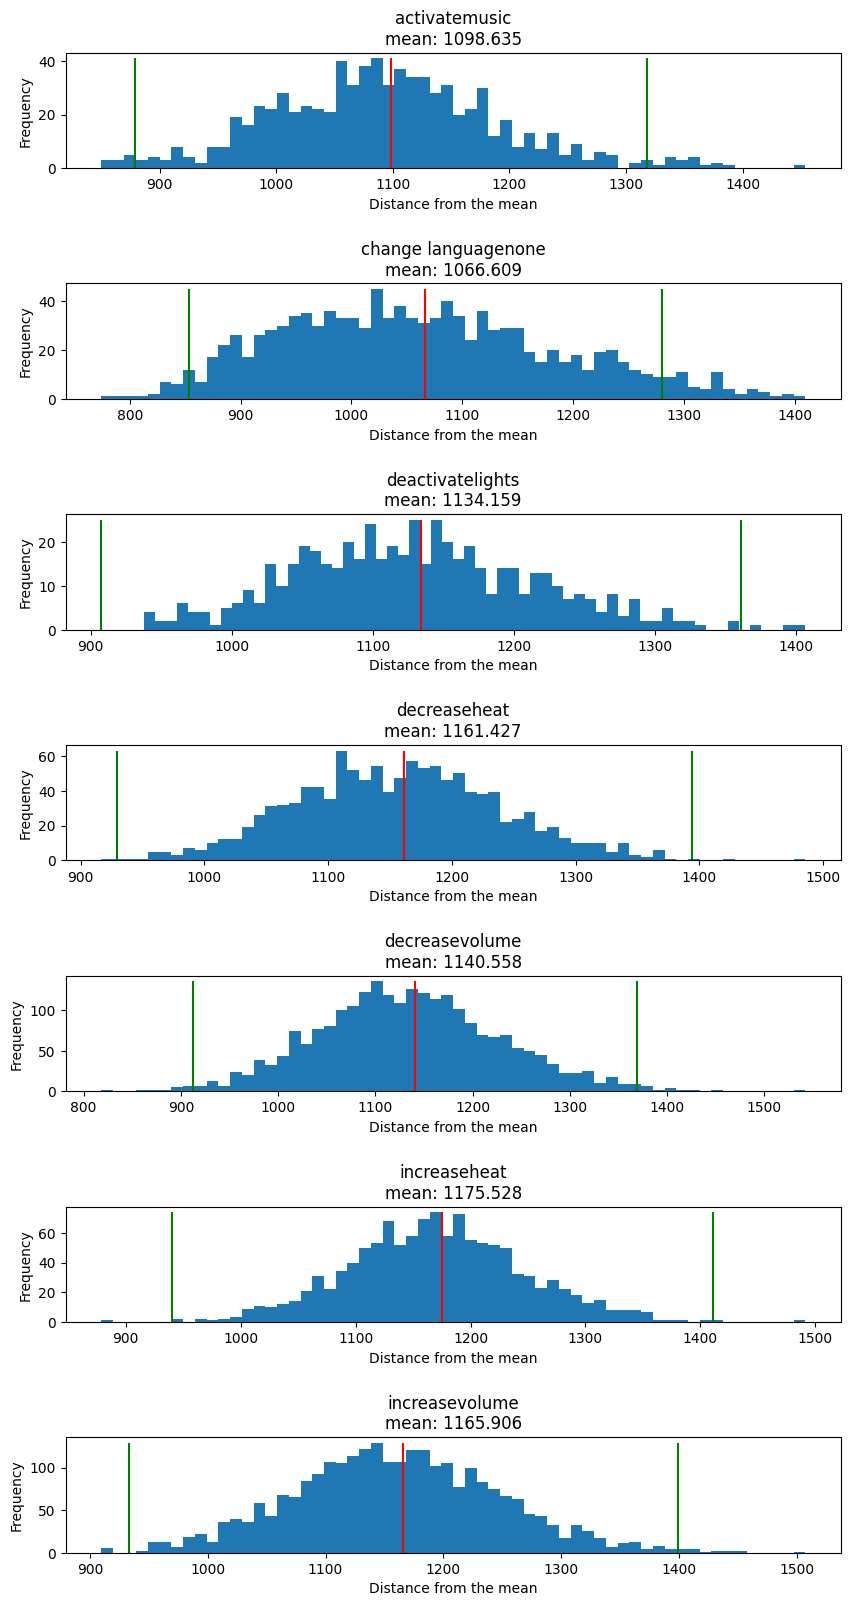

In [69]:
#OUTLIERS DETECTION

outliers = []
all_distances = []
fig,ax = plt.subplots(7, figsize=(10,15))
fig.subplots_adjust(hspace=1, top=1, bottom=0)

dv_distance = []

ind = 0  #Class index
for name, group in groupLabel: 
    
    count = 0 #counting the number of outliers detected for each group
    distances = []
    mfccs_temp = np.array(group['mfccs'].tolist())
    mean = mfccs_temp.mean(axis = 0) #mean of the group
    
    for mfcc in mfccs_temp: 
        dist = distance.cityblock(mfcc, mean)
        distances.append(dist)
        all_distances.append(dist)
        if name == "decreasevolume":
            dv_distance.append(dist)
    distances = np.array(distances)
    
        
    threshold = distances.mean() #the threshold is computed considering the mean of the distances
    
    
    #working with the threshold we can decide how many data we want to consider outliers
    
    for i, mfcc in enumerate(mfccs_temp): 
        if (distances[i] > threshold*1.2 or distances[i]<threshold*0.8): #if too much distant
            count+=1
            #print(group.index[i])
            outliers.append(group.index[i])
    print(f"Outliers {name}: {count}")
    
    hist,edge = np.histogram(distances, bins=60)
    ax[ind].bar(edge[:-1], hist, width=np.diff(edge), align='center')
    ax[ind].vlines(threshold, ymin=0, ymax=max(hist), colors='r')
    ax[ind].vlines([threshold*1.2,threshold*0.8], ymin = 0, ymax=max(hist), colors='g')
    ax[ind].set(title=f'{name}\nmean: {threshold:0.3f}', xlabel='Distance from the mean', ylabel='Frequency')
    ind+=1
print(f"Number of outliers in total: {len(outliers)}")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


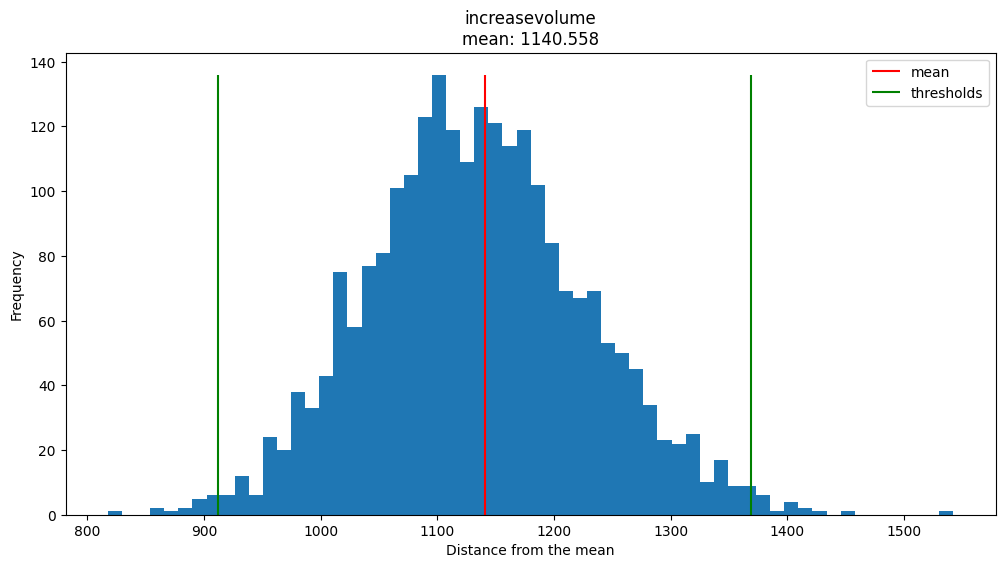

In [70]:
hist,edge = np.histogram(dv_distance, bins=60)
fig,ax = plt.subplots(1, figsize=(12,6))
threshold = np.array(dv_distance).mean()
ax.bar(edge[:-1], hist, width=np.diff(edge), align='center')
ax.vlines(threshold, ymin=0, ymax=max(hist), colors='r', label='mean')
ax.vlines([threshold*1.2,threshold*0.8], ymin = 0, ymax=max(hist), colors='g', label='thresholds')
plt.legend()
ax.set(title=f'{name}\nmean: {threshold:0.3f}', xlabel='Distance from the mean', ylabel='Frequency')
plt.savefig("decvol_plot.eps", format='eps', dpi=1200, bbox_inches='tight')
plt.show()

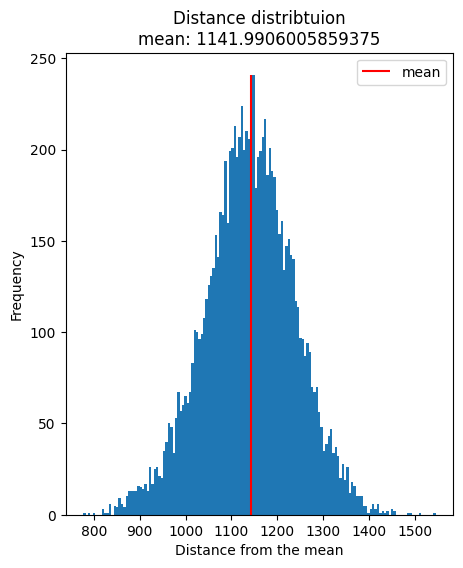

In [71]:
#ALL THE DISTANCES REPRESENTED

hist1, edges1 = np.histogram(all_distances, bins=150)

# Plot the histogram as a bar chart
fig, ax = plt.subplots(1, figsize=(5,6))
ax.bar(edges1[:-1], hist1, width=np.diff(edges1), align='center')
ax.vlines(np.array(all_distances).mean(), ymin=0, ymax=max(hist1), colors='r', label='mean')
ax.set(title=f'Distance distribtuion\nmean: {np.array(all_distances).mean()}', xlabel='Distance from the mean', ylabel='Frequency')
plt.legend()
plt.show()

In [72]:
#Deleting the outliers from the dataset

dataset = dataset.drop(outliers, axis=0)
dataset = dataset.reset_index(drop=True)

In [73]:
#Creating a new array of samples and their labels containing only the relevant audios 

dev_mfcc_final = np.array([mfcc for mfcc in dataset['mfccs']])
new_labels = dataset['labels']

dev_mfcc_final.shape, new_labels.shape

((9594, 1880), (9594,))

In [74]:
#Apply the PCA, feature reduction

dev_mfcc_final, eval_mfcc_final = prepare_data(dev_mfcc_final, eval_mfccs, ncomp=300)
dev_mfcc_final.shape, eval_mfcc_final.shape

((9594, 300), (1455, 300))

{'increasevolume': 2568, 'decreasevolume': 2327, 'increaseheat': 1195, 'decreaseheat': 1180, 'change languagenone': 1027, 'activatemusic': 757, 'deactivatelights': 540}


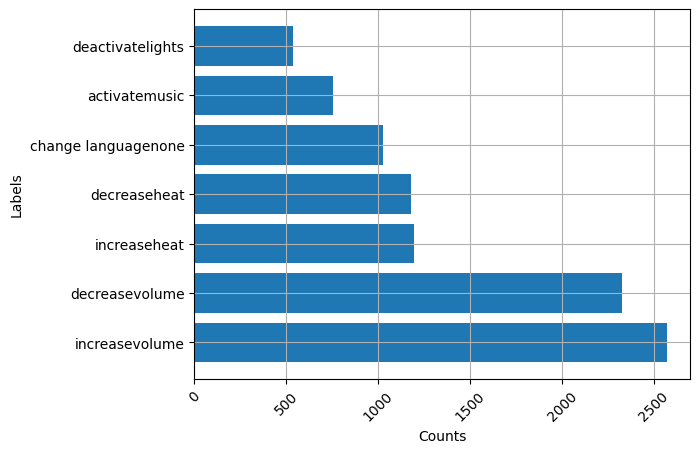

In [75]:
#DISTRIBUTION OF THE CLASSES IN THE DEVELOPMENT SET 

label_counts = dict(Counter(new_labels).most_common())
lab = list(label_counts.keys())
counts = list(label_counts.values())
print(label_counts)
plt.barh(lab, counts)
plt.xlabel('Counts')
plt.xticks(rotation=45)
plt.ylabel('Labels')
#plt.title('Label distribution')

plt.grid()
plt.savefig('Label_distribution_dev.eps', format='eps', dpi=300, bbox_inches='tight')
plt.show()

In [31]:
#Label encoding -> "activatemusic" = 0, ... , "increasevolume" = 6. It slightly improves the model performance

le = LabelEncoder()
le.fit(new_labels)
new_labels = le.transform(new_labels)
le.classes_ 

array(['activatemusic', 'change languagenone', 'deactivatelights',
       'decreaseheat', 'decreasevolume', 'increaseheat', 'increasevolume'],
      dtype=object)

In [85]:
#OVERSAMPLING 
#We use SMOTE function to do a large oversampling and maintaining the proportions of the inital dataset.
#This way we still have an unbalanced dataset, but we have more samples to train the model on. 

k = 1200
sampling_strategy={0:k, 1:k*2, 2:k, 3:k*3, 4:k*5, 5:k*3, 6:k*5} #Maintaining the proportions
sampling_strategy={'activatemusic':k, 'change languagenone':k*2, 'deactivatelights':k, 'decreaseheat':k*3, 'decreasevolume':k*5, 'increaseheat':k*3, 'increasevolume':k*5}
smote = SMOTE(random_state=0, sampling_strategy=sampling_strategy, k_neighbors=1)

dev_mfcc_resampled, new_labels_resampled = smote.fit_resample(dev_mfcc_final,new_labels)

len(new_labels_resampled), len(dev_mfcc_resampled)

(24000, 24000)

{'increasevolume': 6000, 'decreasevolume': 6000, 'increaseheat': 3600, 'decreaseheat': 3600, 'change languagenone': 2400, 'activatemusic': 1200, 'deactivatelights': 1200}


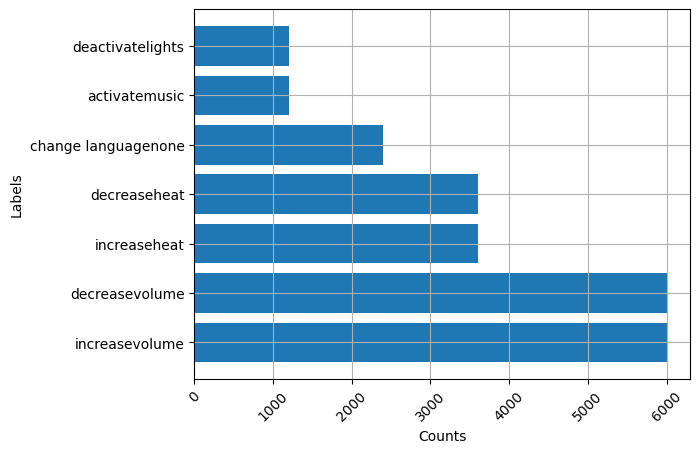

In [79]:
#DISTRIBUTION OF THE CLASSES IN THE DEVELOPMENT SET AFTER OVERSAMPLING

label_counts = dict(Counter(new_labels_resampled).most_common())
lab = list(label_counts.keys())
counts = list(label_counts.values())
print(label_counts)
plt.barh(lab, counts)
plt.xlabel('Counts')
plt.xticks(rotation=45)
plt.ylabel('Labels')
#plt.title('Oversampled Dataset')
plt.grid()
plt.savefig('Label_distribution_dev_oversampled.eps', format='eps', dpi=1200, bbox_inches='tight')

plt.show()


## TRAINING THE MODEL

After analyzing and preprocessing, it is time to build a model to predict the labels of the records in the evaluation set. We create two splits so we can see the differences between normal dataset and oversampled dataset. We choose to allow more room for testing in the oversampled dataset so we do not have an overtrained model on potential noise samples.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(dev_mfcc_final, new_labels, test_size=0.15, random_state=0, stratify=new_labels)

len(X_train[0]), len(y_train), len(X_test), len(y_test), X_train.var()

(300, 8154, 1440, 1440, 1.0001897)

In [41]:
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(dev_mfcc_resampled, new_labels_resampled, test_size=0.25, random_state=0, stratify=new_labels_resampled)
#test_size=0.25
len(X_train_res[0]), len(y_train_res), len(X_test_res), len(y_test_res), X_train_res.var()

(300, 18000, 6000, 6000, 0.93313915)

Here there are different classificators: the best one resulted OneVSRestClassifier with SVC.

In [42]:
clf = OneVsRestClassifier(SVC(C=10, class_weight='balanced', gamma=0.005, random_state=0), n_jobs=-1,verbose=50)
clf.fit(X_train, y_train) 
y_pred = clf.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    7.5s remaining:   18.7s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    7.6s remaining:   10.1s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:   12.8s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:   17.2s remaining:    6.9s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:   23.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:   23.8s finished


In [87]:
clf_res = OneVsRestClassifier(SVC(C=11, class_weight='balanced', gamma=0.005, random_state=0, max_iter=2000), n_jobs=-1)
clf_res.fit(X_train_res, y_train_res) 
y_pred_res = clf_res.predict(X_test_res)

/usr/local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider

In [81]:
clf2 = SVC(C=10, class_weight='balanced', gamma=0.0045, random_state=0)
clf2.fit(X_train, y_train) 
y_pred2 = clf2.predict(X_test)
f1_svc = f1_score(y_test, y_pred2, average='macro')
accuracy_svc = accuracy_score(y_test, y_pred2)

In [45]:
clf3 = RandomForestClassifier(n_estimators=500, class_weight='balanced', n_jobs=-1, random_state=0,verbose=1)
clf3.fit(X_train, y_train) 
y_pred3 = clf3.predict(X_test)
f1_rf = f1_score(y_test, y_pred3, average='macro')
accuracy_rf = accuracy_score(y_test, y_pred3)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   25.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.2s finished


In [ ]:
#The param grid permits us to tune in the best way the hyperparameters, 
#assigning possible values to them and comparing all the result obtained by the model generated



estimator = OneVsRestClassifier(SVC(class_weight='balanced', random_state=0))
param_grid = {'estimator__C': [10,8,11],'estimator__gamma':[0.0045, 0.009,0.005], 'estimator__max_iter':[1500,2000,-1]}
gridsearch = GridSearchCV(estimator, param_grid, cv=5, scoring='accuracy', verbose=20)

gridsearch.fit(X_train_res, y_train_res)
print("Best parameters: ", gridsearch.best_params_)
print("Best score: ", gridsearch.best_score_)

y_pred = gridsearch.predict(X_test_res)
#In order to achieve the best results we used the grideaserch 
#We found that C=11, gamma = 0.005, max_iter = 2000 are the best hyperparameters 

## OUTCOMES AND CONCLUSIONS

In [46]:
#After decoding the labels, given the model obtained we compute the accuracy, precision, recall, F1 scores.
#The results are quite convincing

y_testl = le.inverse_transform(y_test)
y_predl = le.inverse_transform(y_pred)
f1_ovr = f1_score(y_testl, y_predl, average='macro')
accuracy_ovr = accuracy_score(y_testl, y_predl)
print(f"F1-score: {f1_ovr}\n")
print(f"Accuracy: {accuracy_ovr}\n")
report = classification_report(y_testl, y_predl)
print(report)

F1-score: 0.8736410554818603

Accuracy: 0.8729166666666667

                     precision    recall  f1-score   support

      activatemusic       0.92      0.93      0.93       114
change languagenone       0.95      0.94      0.94       154
   deactivatelights       0.97      0.78      0.86        81
       decreaseheat       0.84      0.79      0.81       177
     decreasevolume       0.87      0.88      0.88       349
       increaseheat       0.81      0.81      0.81       179
     increasevolume       0.86      0.91      0.88       386

           accuracy                           0.87      1440
          macro avg       0.89      0.86      0.87      1440
       weighted avg       0.87      0.87      0.87      1440



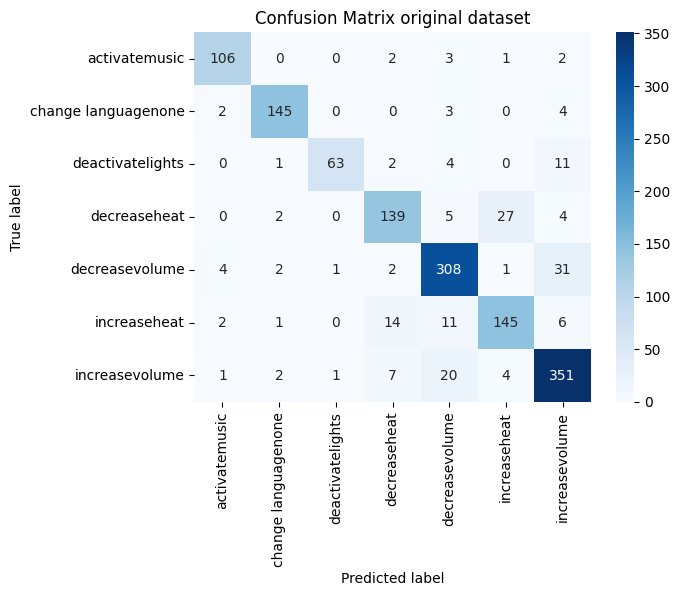

In [47]:
#Confusion matrix, to better understand where the model fails to classify.

cm = confusion_matrix(y_testl, y_predl)
labs = np.unique(le.inverse_transform(new_labels))
# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=labs, yticklabels=labs)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix original dataset")
plt.show()


{'increasevolume': 409, 'decreasevolume': 354, 'increaseheat': 178, 'decreaseheat': 166, 'change languagenone': 153, 'activatemusic': 115, 'deactivatelights': 65}


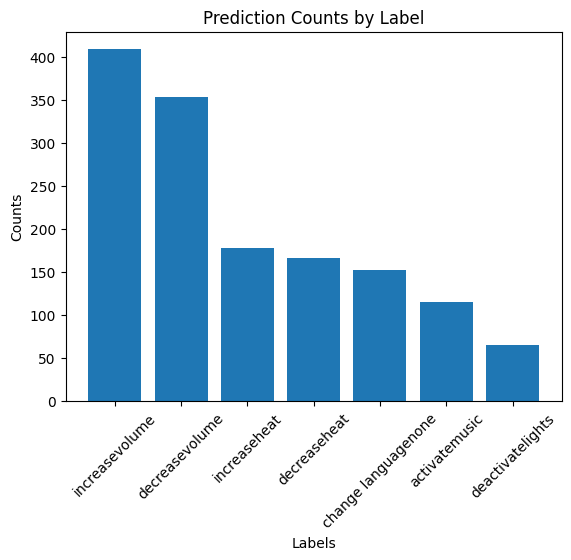

In [48]:
label_counts = dict(Counter(y_predl).most_common())
lab = list(label_counts.keys())
counts = list(label_counts.values())
print(label_counts)
plt.bar(lab, counts)
plt.xlabel('Labels')
plt.xticks(rotation=45)
plt.ylabel('Counts')
plt.title('Prediction Counts by Label')
plt.show()

In [49]:
y_testl_res = le.inverse_transform(y_test_res)
y_predl_res = le.inverse_transform(y_pred_res)
f1_ovr_res = f1_score(y_testl_res, y_predl_res, average='macro')
accuracy_ovr_res = accuracy_score(y_testl_res, y_predl_res)
print(f"F1-score: {f1_ovr_res}\n")
print(f"Accuracy: {accuracy_ovr_res}\n")
report_res = classification_report(y_testl_res, y_predl_res)
print(report_res)

F1-score: 0.9871142037505704

Accuracy: 0.9881666666666666

                     precision    recall  f1-score   support

      activatemusic       0.99      0.97      0.98       300
change languagenone       0.99      0.99      0.99       600
   deactivatelights       0.99      0.97      0.98       300
       decreaseheat       0.99      0.99      0.99       900
     decreasevolume       0.99      0.99      0.99      1500
       increaseheat       0.99      0.99      0.99       900
     increasevolume       0.98      0.99      0.99      1500

           accuracy                           0.99      6000
          macro avg       0.99      0.99      0.99      6000
       weighted avg       0.99      0.99      0.99      6000



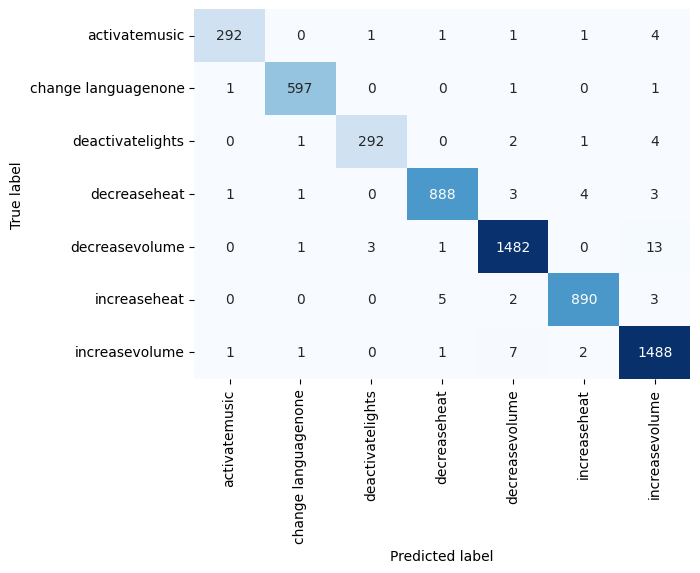

In [50]:
#Confusion matrix, to better understand where the model fails.

cm = confusion_matrix(y_testl_res, y_predl_res)

labs = np.unique(le.inverse_transform(new_labels_resampled))
# Plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=labs, yticklabels=labs)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix oversampled dataset")
plt.savefig("confusion_matrix_oversmapled.eps", format="eps", dpi=1200, bbox_inches='tight')
plt.show()


{'increasevolume': 1516, 'decreasevolume': 1498, 'increaseheat': 898, 'decreaseheat': 896, 'change languagenone': 601, 'deactivatelights': 296, 'activatemusic': 295}


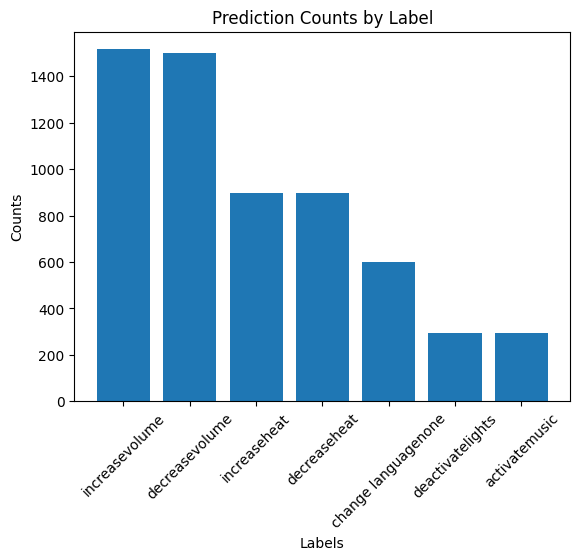

In [51]:
label_counts = dict(Counter(y_predl_res).most_common())
lab = list(label_counts.keys())
counts = list(label_counts.values())
print(label_counts)
plt.bar(lab, counts)
plt.xlabel('Labels')
plt.xticks(rotation=45)
plt.ylabel('Counts')
plt.title('Prediction Counts by Label')
plt.show()


As we can see, with an oversampled dataset we have slightly better results. Since we have a lot more data to train we have also to be aware of possibile overfitting so that's why we need a proper hyperparameter tuning.

In [52]:
#Full classifier comparison
table = PrettyTable()
table.field_names = ["Classifier", "F1-macro", "Accuracy"]
table.add_row(["SVC", round(f1_svc,4), round(accuracy_svc,4)])
table.add_row(["RandomForest", round(f1_rf,4), round(accuracy_rf,4)])
table.add_row(["OneVsRestClassifier(SVC)", round(f1_ovr,4), round(accuracy_ovr,4)])
table.add_row(["OneVsRestClassifier2(SVC)", round(f1_ovr_res,4), round(accuracy_ovr_res,4)])
table

Classifier,F1-macro,Accuracy
SVC,0.8658,0.8653
RandomForest,0.5861,0.6292
OneVsRestClassifier(SVC),0.8736,0.8729
OneVsRestClassifier2(SVC),0.9871,0.9882


# Evaluation

In [53]:
#Once we are satisfied with our results we do the prediction on the official evaluation set.

eval_pred = clf_res.predict(eval_mfcc_final)
eval_pred.shape

(1455,)

{'increasevolume': 406, 'decreasevolume': 349, 'decreaseheat': 176, 'increaseheat': 166, 'change languagenone': 156, 'activatemusic': 120, 'deactivatelights': 82}


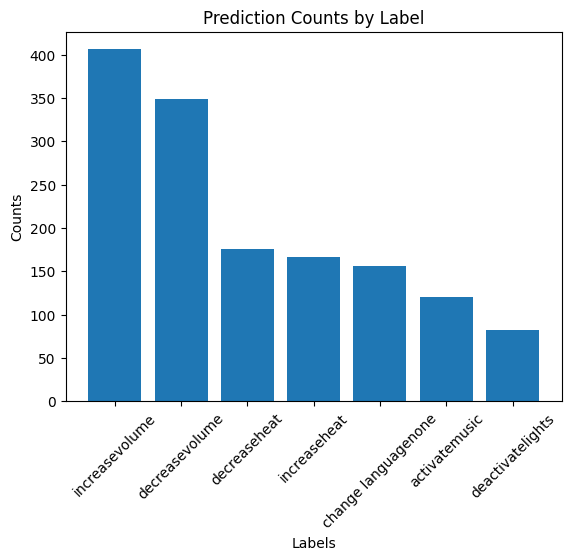

In [54]:
#Distribution of the classes predicted by the model in the evaluation set

eval_pred = le.inverse_transform(eval_pred)
label_counts = dict(Counter(eval_pred).most_common())
labs = list(label_counts.keys())
counts = list(label_counts.values())
print(label_counts)
plt.bar(labs, counts)
plt.xlabel('Labels')
plt.xticks(rotation=45)
plt.ylabel('Counts')
plt.title('Prediction Counts by Label')
plt.show()

In [55]:
#Saving the label associated to every record in a file

df_pred = pd.DataFrame({'Id': range(len(eval_pred)), 'Predicted': eval_pred})
timestamp = strftime("%Y%m%d-%H%M%S")
df_pred.to_csv(f'submission_{timestamp}.csv', index = False, header=True)